Whole Analysis of Univariate Time Series with LSTM

In [1]:
# for Neurokit2:

import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# for Tensorflow:

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Simulate Data
## Raw Data (all that is needed for now)

<class 'numpy.ndarray'>


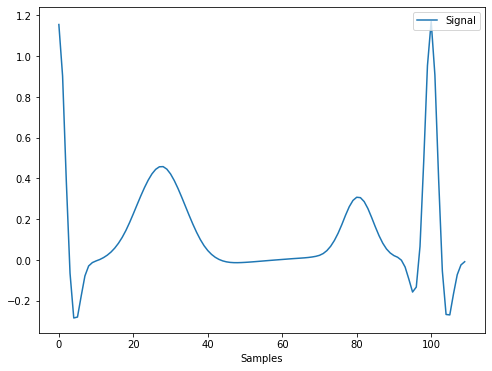

In [18]:
# n = 1, 1.000 s, 100 Hz
ecg = nk.ecg_simulate(duration=100, sampling_rate=100, noise=0.0, heart_rate=60, heart_rate_std=0, method='ecgsyn') # Alternate heart rate and noise levels

print(type(ecg))

nk.signal_plot(ecg[100:210])
#plt.plot(sample_raw[:30000]) #it's the same

## Data Processing

What is needed:
- ECG_Raw
- ECG_Clean
- ECG_Rate
- ECG_Quality
- ECG_R_Peaks

-> ecg_clean ecg_peaks ecg_quality



ecg_simulate(duration=10, length=None, sampling_rate=1000, noise=0.01, heart_rate=70, heart_rate_std=1, method='ecgsyn', random_state=None)

ecg_clean(ecg_signal, sampling_rate=1000, method='neurokit')

 ecg_rate(peaks, sampling_rate=1000, desired_length=None, interpolation_method='monotone_cubic')
 
  ecg_quality(ecg_cleaned, rpeaks=None, sampling_rate=1000, method='averageQRS', approach=None)
  
  
  
 ecg_peaks(ecg_cleaned, sampling_rate=1000, method='neurokit', correct_artifacts=False)
 
 ecg_segment(ecg_cleaned, rpeaks=None, sampling_rate=1000, show=False)
 
 
 
 ecg_plot(ecg_signals, rpeaks=None, sampling_rate=None, show_type='default')

#Default processing pipeline
signals, info = nk.ecg_process(sample_raw, sampling_rate=1000)

signals2 = nk.ecg_intervalrelated(signals, sampling_rate=1000)

signals.head()


#Visualize
ecg_df = pd.DataFrame({"Raw": signals["ECG_Raw"],
                       "Processed": signals["ECG_Clean"]})

#nk.signal_plot(ecg_df[:30000], subplots=True)
nk.ecg_plot(ecg_df[:30000])

ecg2 = signals["ECG_Clean"].tolist()

print(ecg2[:30])
plt.plot(ecg[1000:10000])
plt.plot(ecg2[980:9980])

# LSTM

In [3]:
len(ecg)

10000

In [4]:
# Code from Brownlee 2018

# univariate multi-step vector-output stacked lstm example
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 100, 10
# split into samples
X, y = split_sequence(ecg, n_steps_in, n_steps_out)
# summarize the data
print(len(ecg))
print(X.shape,y.shape)

10000
(9891, 100) (9891, 10)


"The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features]"

In [6]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
print(X.shape,y.shape)

(9891, 100, 1) (9891, 10, 1)


In [7]:
# define model
model = Sequential()
model.add(LSTM(20, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features)))
model.add(LSTM(20, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=5, verbose=0)

In [8]:
# demonstrate prediction
x_input = ecg[100:200]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 1.0531083   0.78475064  0.4587059   0.05486239 -0.18921703 -0.20802109
  -0.09601423 -0.05261961  0.0558246   0.02186985]]


In [9]:
pl = np.append(ecg[100:200],yhat[0,:])

In [17]:
yhat.shape

(1, 10)

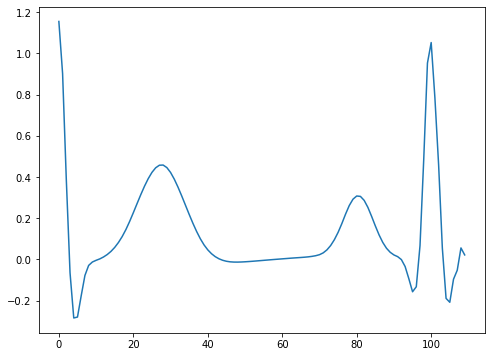

In [10]:
plt.plot(pl)